In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/22739
# 标题：K线形态识别与验证

# 导入必备模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import talib as tb  # 当前重点库 TA-LIB
import seaborn as sns
from jqdata import *
sns.set()

In [2]:
### 定义形态查寻函数
def find_pattern(function):
    '''从全市场中“随机”的挑选标的，快速的找到一个符合形态的标的与对应时间
    Args:
        function: ta-lib 库中的一个方法
    Return:
        返回(stock, date)
    '''
    
    # 打乱全市场标的顺序
    stock_list = get_all_securities().index.tolist()
    np.random.shuffle(stock_list)
    
    # 构造时间序列的结点，从10天之前的时间序列查找
    trade_date = get_trade_days(end_date=dt.datetime.now(), count=15)
    check_date = trade_date[-10]
    
    for stock in stock_list:
        try:
            price = get_price(stock, end_date=check_date, count=244 * 5)
            signal = function(price['open'], price['high'],
                              price['low'], price['close'])
            signal = signal[signal != 0]
            if len(signal) > 0:
                return stock, signal.index[0]
        except:
            continue

In [3]:
### k 线刻画数据处理
def get_k_value(pattern, count):
    '''将开、高、低、收价格数据进行处理，以支持K线图展示
    Args:
        pattern: 形态函数返回的标的与时间元组
        count: 形态数量
    Return:
        返回处理后的价格数据，类型为df
    '''

    # 获取21个价格序列值，并且让形态时间大致处于中间
    security = pattern[0]
    check_date = pattern[1]
    pattern_date = get_trade_days(end_date=check_date, count=count)
    orther_count = (21 - count) // 2
    trade_date = get_trade_days(start_date=check_date, end_date=dt.datetime.now())
    end_date = trade_date[9]
    price = get_price(security, end_date=end_date, 
                      count=21)[['open', 'high', 'low', 'close']]
    y_list = {'y1': [], 'y2': [], 'y3': [], 'y4': [], 'c': [], 'al': []}
    
    # 数据处理
    for i in range(price.shape[0]):
        # 计算各bar的透明度
        if price.index[i].date() in pattern_date:
            y_list['al'].append(1)
        else:
            y_list['al'].append(0.2)
        
        # 计算各实体的长度
        if price.open[i] > price.close[i]:
            y_list['y1'].append(price.close[i])
            y_list['y2'].append(price.open[i] - price.close[i])
            y_list['c'].append('g')
        else:
            y_list['y1'].append(price.open[i])
            y_list['y2'].append(price.close[i] - price.open[i])
            y_list['c'].append('r')
        
        # 计算各影线的长度
        if price.high[i] > price.low[i]:
            y_list['y3'].append(price.low[i])
            y_list['y4'].append(price.high[i] - price.low[i])
        else:
            y_list['y3'].append(price.high[i])
            y_list['y4'].append(price.low[i] - price.high[i])
            
    for name, value in y_list.items():
        price.loc[:, name] = value

    return price

In [4]:
### k 线形态刻画 
def show_bar(data, title='None'):
    '''将价格数据按实体与影线进行组合
    Args:
        data: 处理好的价格数据，df类型
        title: 图片标题，可选
    Return:
        None
    '''

    # 整合 x 轴与 y 轴数据
    x = [str(date.date()) for date in data.index]
    y1 = data['y1']
    y2 = data['y2']

    y3 = data['y3']
    y4 = data['y4']
    
    fig = plt.figure(figsize=(18, 5))
    # 画影线，要求对应不同的颜色与透明度
    for i in range(len(data)):
        plt.bar(x[i], y3[i], align='center', alpha=0)
        plt.bar(x[i], y4[i], align='center', color=data['c'][i], 
                alpha=data['al'][i], bottom=y3[i], width=0.1)

    # 画实体，要求对应不同的颜色与透明度
    for j in range(len(data)):
        plt.bar(x[j], y1[j], align='center', alpha=0)
        plt.bar(x[j], y2[j], align='center', color=data['c'][j], 
                alpha=data['al'][j], bottom=y1[j])
    
    _min = data[['open', 'high', 'low', 'close']].min().min() - 0.1
    _max = data[['open', 'high', 'low', 'close']].max().max() + 0.1

    plt.ylim(_min, _max)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

In [5]:
### 函数组合-形态检测
def check_bar(fuc, bar_count):
    # 查询形态
    pattern = find_pattern(fuc)
    # bar 数据处理
    k_value = get_k_value(pattern, bar_count)
    # 形态展示
    show_bar(k_value, pattern[0] + ': ' + fuc.__name__)

---

### CDL2CROWS - Two Crows
> 函数名：CDL2CROWS   
名称：Two Crows 两只乌鸦   
简介：三日K线模式，第一天长阳，第二天高开收阴，第三天再次高开继续收阴，
收盘比前一日收盘价低，预示股价下跌。

```python
integer = CDL2CROWS(open, high, low, close)
```

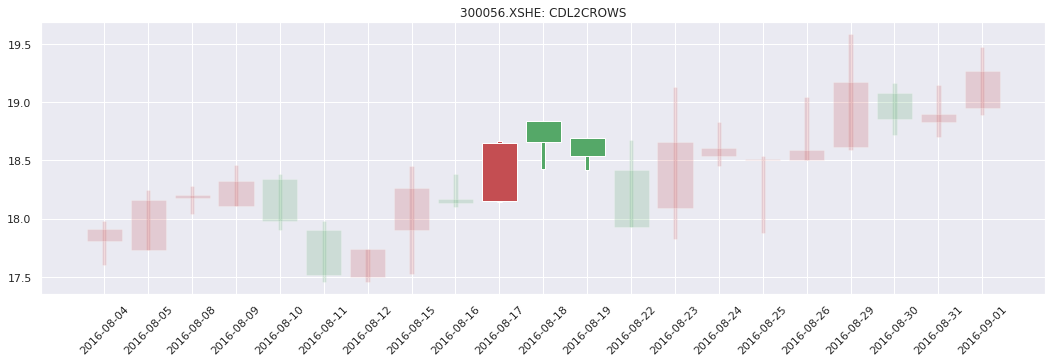

In [151]:
check_bar(tb.CDL2CROWS, 3)

### CDL3BLACKCROWS - Three Black Crows
> 函数名：CDL3BLACKCROWS   
名称：Three Black Crows 三只乌鸦   
简介：三日K线模式，连续三根阴线，每日收盘价都下跌且接近最低价，
每日开盘价都在上根K线实体内，预示股价下跌。   

```python
integer = CDL3BLACKCROWS(open, high, low, close)
```

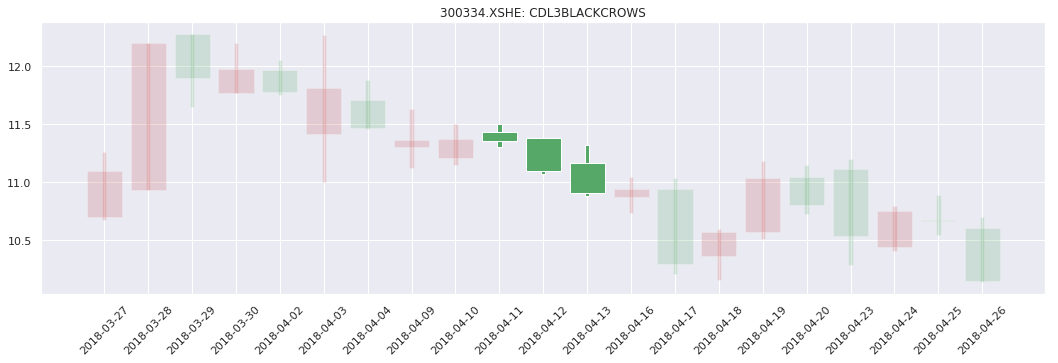

In [153]:
check_bar(tb.CDL3BLACKCROWS, 3)

### CDL3INSIDE - Three Inside Up/Down
> 函数名：CDL3INSIDE   
名称： Three Inside Up/Down 三内部上涨和下跌   
简介：三日K线模式，母子信号+长K线，以三内部上涨为例，K线为阴阳阳，
第三天收盘价高于第一天开盘价，第二天K线在第一天K线内部，预示着股价上涨。
   
```python
integer = CDL3INSIDE(open, high, low, close)
```

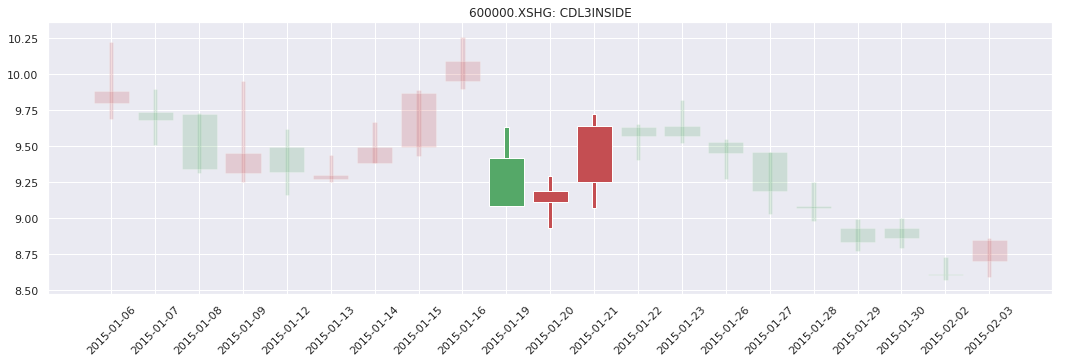

In [154]:
check_bar(tb.CDL3INSIDE, 3)

### CDL3LINESTRIKE - Three-Line Strike 
> 函数名：CDL3LINESTRIKE   
名称： Three-Line Strike 三线打击   
简介：四日K线模式，前三根阳线，每日收盘价都比前一日高，
开盘价在前一日实体内，第四日市场高开，收盘价低于第一日开盘价，预示股价下跌。
   
```python
integer = CDL3LINESTRIKE(open, high, low, close)
```

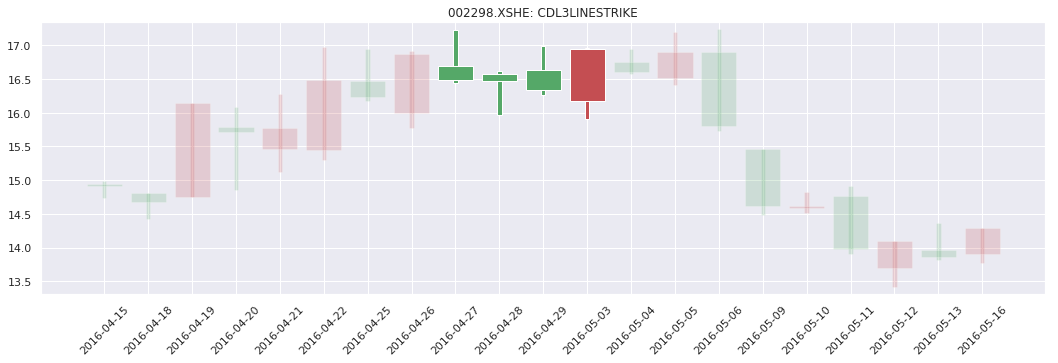

In [155]:
check_bar(tb.CDL3LINESTRIKE, 4)

### CDL3OUTSIDE - Three Outside Up/Down
> 函数名：CDL3OUTSIDE  
名称：Three Outside Up/Down 三外部上涨和下跌   
简介：三日K线模式，与三内部上涨和下跌类似，K线为阴阳阳，但第一日与第二日的K线形态相反，
以三外部上涨为例，第一日K线在第二日K线内部，预示着股价上涨。  

```python
integer = CDL3OUTSIDE(open, high, low, close)
```

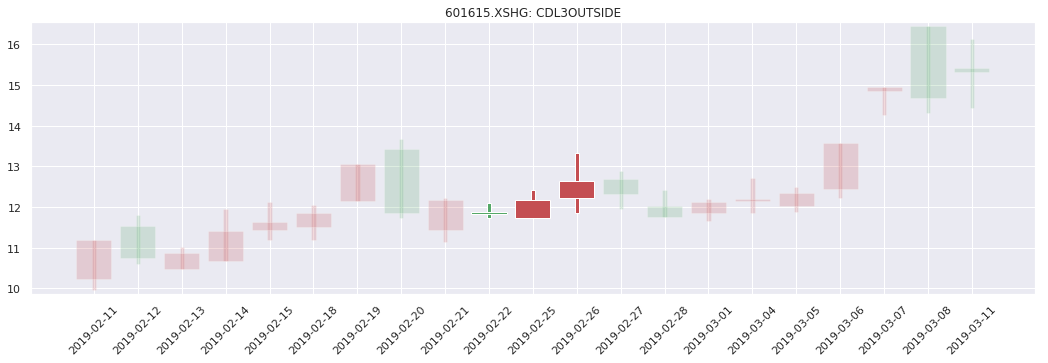

In [158]:
check_bar(tb.CDL3OUTSIDE, 3)

### CDL3STARSINSOUTH - Three Stars In The South
> 函数名：CDL3STARSINSOUTH  
名称：Three Stars In The South 南方三星  
简介：三日K线模式，与大敌当前相反，三日K线皆阴，第一日有长下影线，
第二日与第一日类似，K线整体小于第一日，第三日无下影线实体信号，
成交价格都在第一日振幅之内，预示下跌趋势反转，股价上升。  

```python
integer = CDL3STARSINSOUTH(open, high, low, close)
```

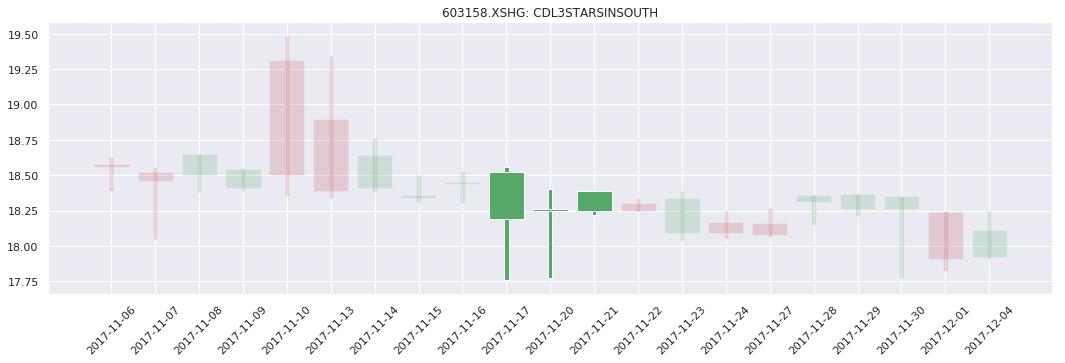

In [160]:
check_bar(tb.CDL3STARSINSOUTH, 3)

### CDL3WHITESOLDIERS - Three Advancing White Soldiers
> 函数名：CDL3WHITESOLDIERS   
名称：Three Advancing White Soldiers 三个白兵  
简介：三日K线模式，三日K线皆阳，
每日收盘价变高且接近最高价，开盘价在前一日实体上半部，预示股价上升。

```python
integer = CDL3WHITESOLDIERS(open, high, low, close)
```

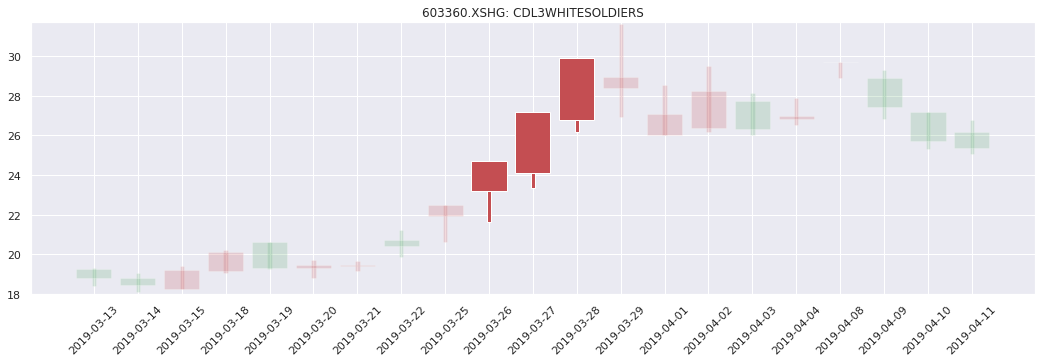

In [161]:
check_bar(tb.CDL3WHITESOLDIERS, 3)

### CDLABANDONEDBABY - Abandoned Baby
> 函数名：CDLABANDONEDBABY  
名称：Abandoned Baby 弃婴  
简介：三日K线模式，第二日价格跳空且收十字星（开盘价与收盘价接近，
最高价最低价相差不大），预示趋势反转，发生在顶部下跌，底部上涨。  

```python
integer = CDLABANDONEDBABY(open, high, low, close, penetration=0)
```

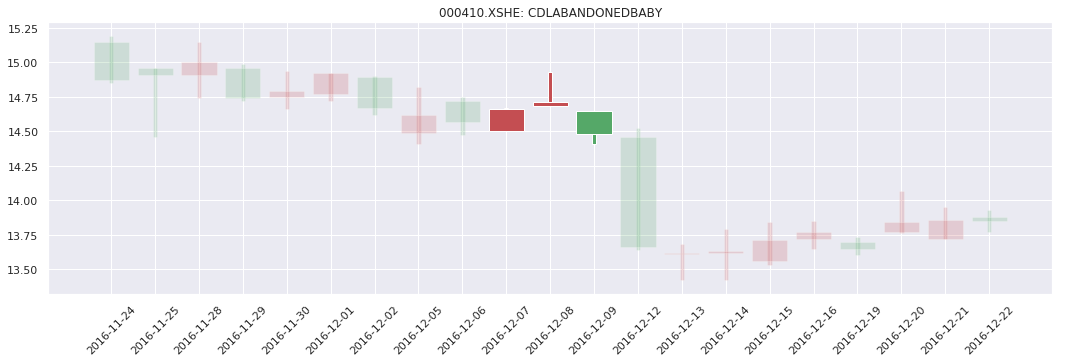

In [163]:
check_bar(tb.CDLABANDONEDBABY, 3)

### CDLADVANCEBLOCK - Advance Block
> 函数名：CDLADVANCEBLOCK   
名称：Advance Block 大敌当前   
简介：三日K线模式，三日都收阳，每日收盘价都比前一日高，
开盘价都在前一日实体以内，实体变短，上影线变长。   

```python
integer = CDLADVANCEBLOCK(open, high, low, close)
```

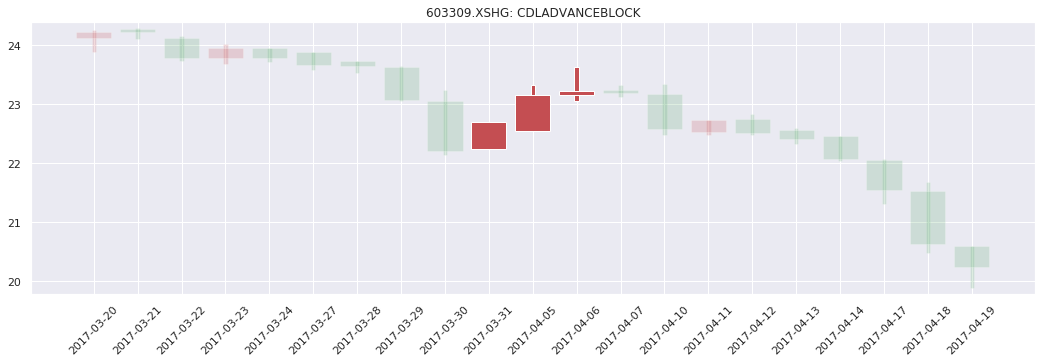

In [164]:
check_bar(tb.CDLADVANCEBLOCK, 3)

### CDLBELTHOLD - Belt-hold
> 函数名：CDLBELTHOLD   
名称：Belt-hold 捉腰带线   
简介：两日K线模式，下跌趋势中，第一日阴线，
第二日开盘价为最低价，阳线，收盘价接近最高价，预示价格上涨。   

```python
integer = CDLBELTHOLD(open, high, low, close)
```

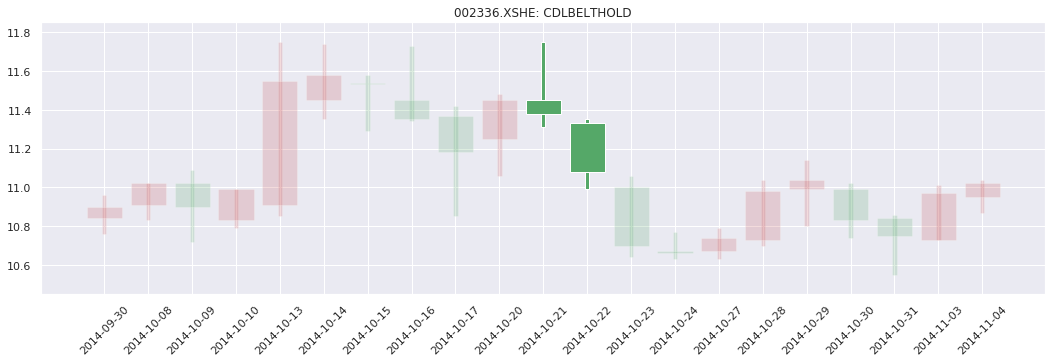

In [169]:
check_bar(tb.CDLBELTHOLD, 2)

### CDLBREAKAWAY - Breakaway
> 函数名：CDLBREAKAWAY  
名称：Breakaway 脱离  
简介：五日K线模式，以看涨脱离为例，下跌趋势中，第一日长阴线，第二日跳空阴线，延续趋势开始震荡，
第五日长阳线，收盘价在第一天收盘价与第二天开盘价之间，预示价格上涨。   

```python
integer = CDLBREAKAWAY(open, high, low, close)
```

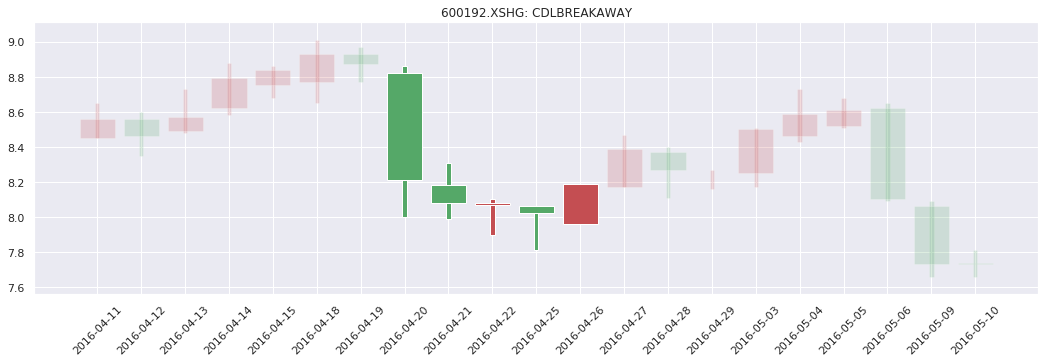

In [172]:
check_bar(tb.CDLBREAKAWAY, 5)

### CDLCLOSINGMARUBOZU - Closing Marubozu
> 函数名：CDLCLOSINGMARUBOZU   
名称：Closing Marubozu 收盘缺影线  
简介：一日K线模式，以阳线为例，最低价低于开盘价，收盘价等于最高价，
预示着趋势持续。

```python
integer = CDLCLOSINGMARUBOZU(open, high, low, close)
```

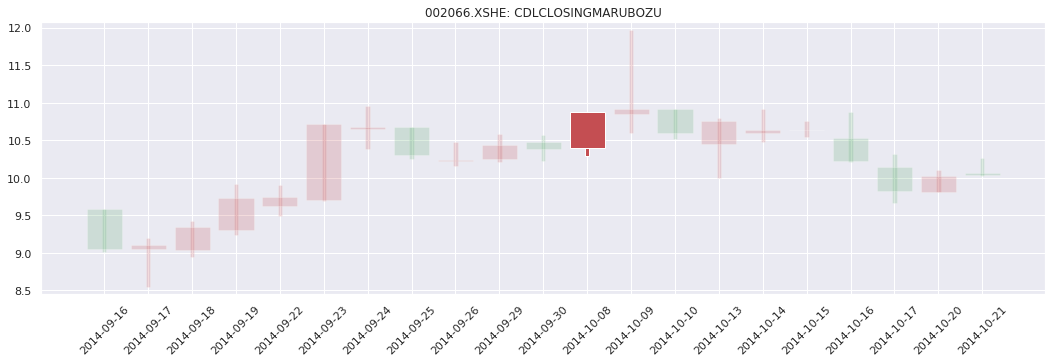

In [173]:
check_bar(tb.CDLCLOSINGMARUBOZU, 1)

### CDLCONCEALBABYSWALL - Concealing Baby Swallow
> 函数名：CDLCONCEALBABYSWALL   
名称： Concealing Baby Swallow 藏婴吞没   
简介：四日K线模式，下跌趋势中，前两日阴线无影线
，第二日开盘、收盘价皆低于第二日，第三日倒锤头，
第四日开盘价高于前一日最高价，收盘价低于前一日最低价，预示着底部反转。   

```python
integer = CDLCONCEALBABYSWALL(open, high, low, close)
```

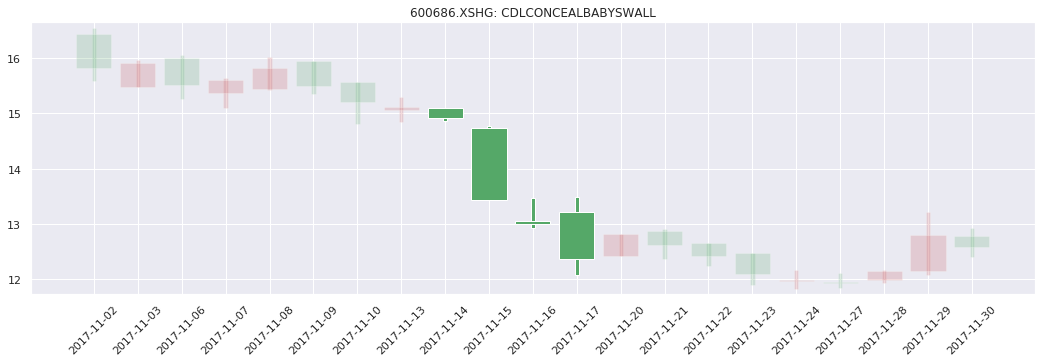

In [174]:
check_bar(tb.CDLCONCEALBABYSWALL, 4)

### CDLCOUNTERATTACK - Counterattack
> 函数名：CDLCOUNTERATTACK  
名称：Counterattack 反击线  
简介：二日K线模式，与分离线类似。  

```python
integer = CDLCOUNTERATTACK(open, high, low, close)
```

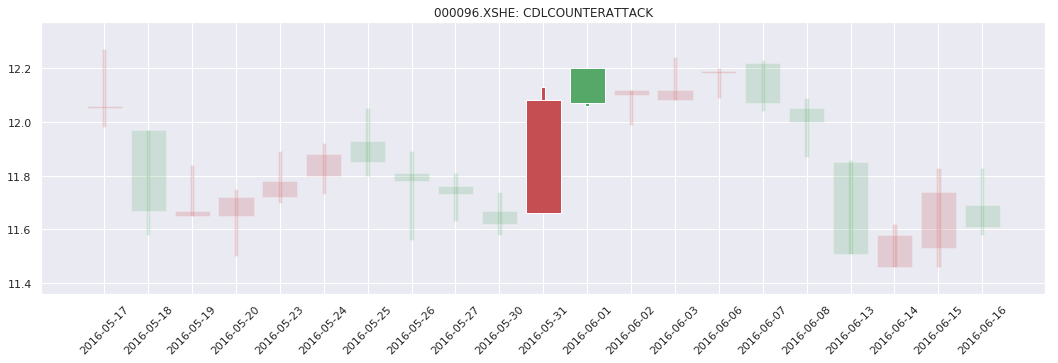

In [175]:
check_bar(tb.CDLCOUNTERATTACK, 2)

### CDLDARKCLOUDCOVER - Dark Cloud Cover
> 函数名：CDLDARKCLOUDCOVER  
名称：Dark Cloud Cover 乌云压顶  
简介：二日K线模式，第一日长阳，第二日开盘价高于前一日最高价，
收盘价处于前一日实体中部以下，预示着股价下跌。  

```python
integer = CDLDARKCLOUDCOVER(open, high, low, close, penetration=0)
```

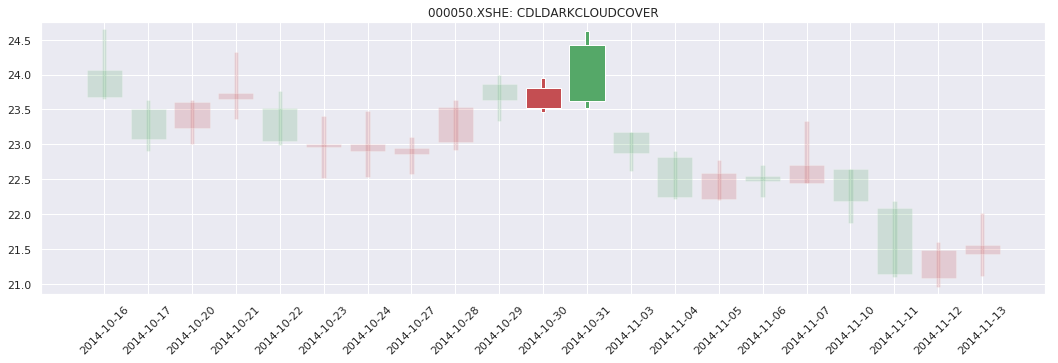

In [176]:
check_bar(tb.CDLDARKCLOUDCOVER, 2)

### CDLDOJI - Doji
> 函数名：CDLDOJI  
名称：Doji 十字  
简介：一日K线模式，开盘价与收盘价基本相同。  

```python
integer = CDLDOJI(open, high, low, close)
```

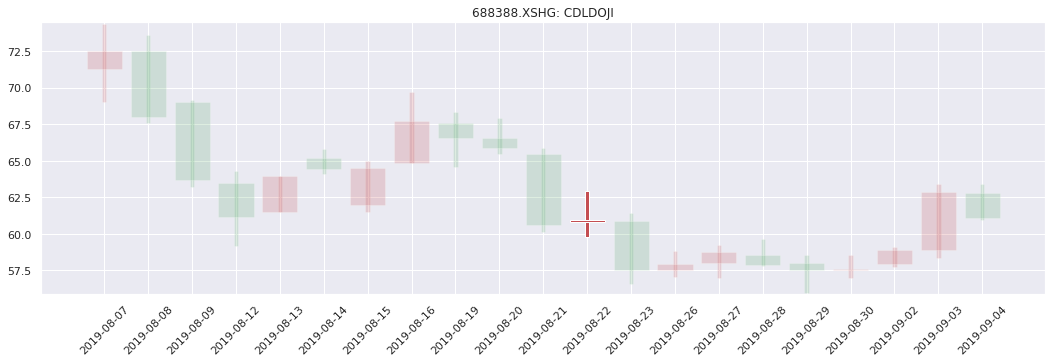

In [180]:
check_bar(tb.CDLDOJI, 1)

### CDLDOJISTAR - Doji Star
> 函数名：CDLDOJISTAR  
名称：Doji Star 十字星  
简介：一日K线模式，开盘价与收盘价基本相同，上下影线不会很长，预示着当前趋势反转。  

```python
integer = CDLDOJISTAR(open, high, low, close)
```

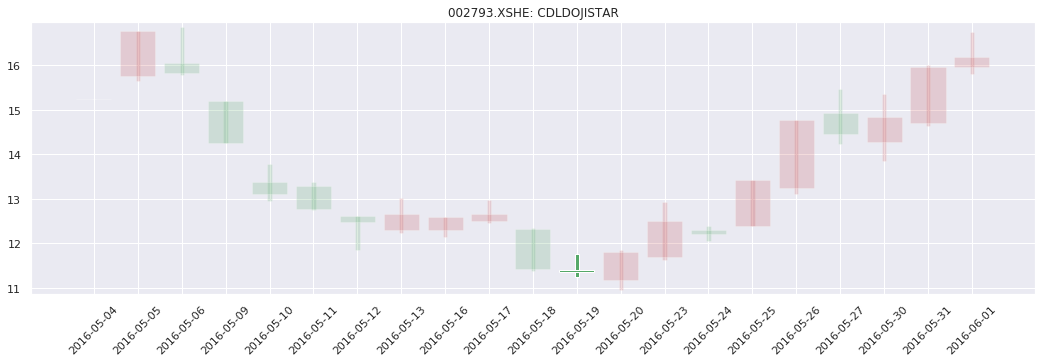

In [181]:
check_bar(tb.CDLDOJISTAR, 1)

### CDLDRAGONFLYDOJI - Dragonfly Doji
> 函数名：CDLDRAGONFLYDOJI  
名称：Dragonfly Doji 蜻蜓十字/T形十字  
简介：一日K线模式，开盘后价格一路走低，
之后收复，收盘价与开盘价相同，预示趋势反转。  

```python
integer = CDLDRAGONFLYDOJI(open, high, low, close)
```

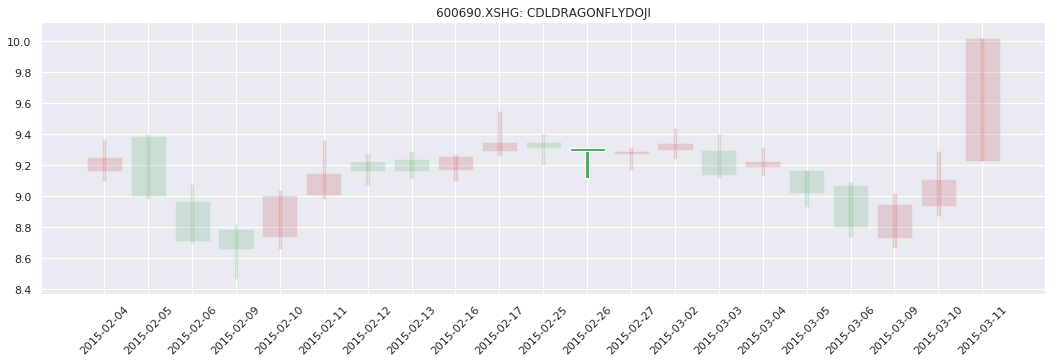

In [182]:
check_bar(tb.CDLDRAGONFLYDOJI, 1)

### CDLENGULFING - Engulfing Pattern
> 函数名：CDLENGULFING  
名称：Engulfing Pattern 吞噬模式  
简介：两日K线模式，分多头吞噬和空头吞噬，以多头吞噬为例，第一日为阴线，
第二日阳线，第一日的开盘价和收盘价在第二日开盘价收盘价之内，但不能完全相同。  

```python
integer = CDLENGULFING(open, high, low, close)
```

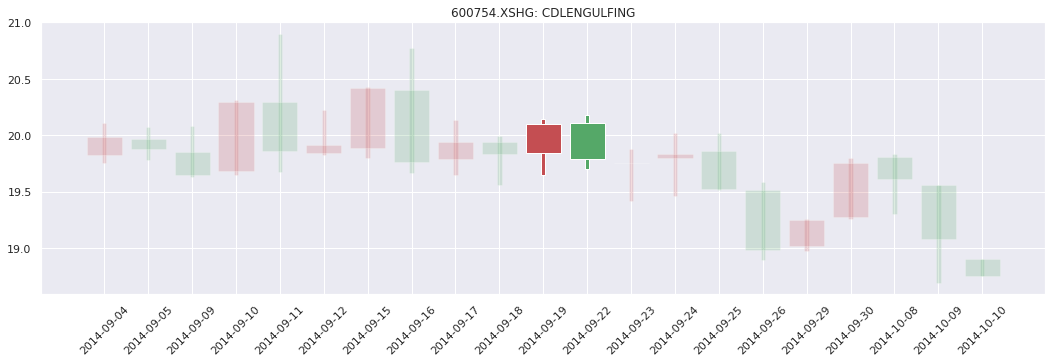

In [184]:
check_bar(tb.CDLENGULFING, 2)

### CDLEVENINGDOJISTAR - Evening Doji Star
> 函数名：CDLEVENINGDOJISTAR  
名称：Evening Doji Star 十字暮星  
简介：三日K线模式，基本模式为暮星，第二日收盘价和开盘价相同，预示顶部反转。  

```python
integer = CDLEVENINGDOJISTAR(open, high, low, close, penetration=0)
```

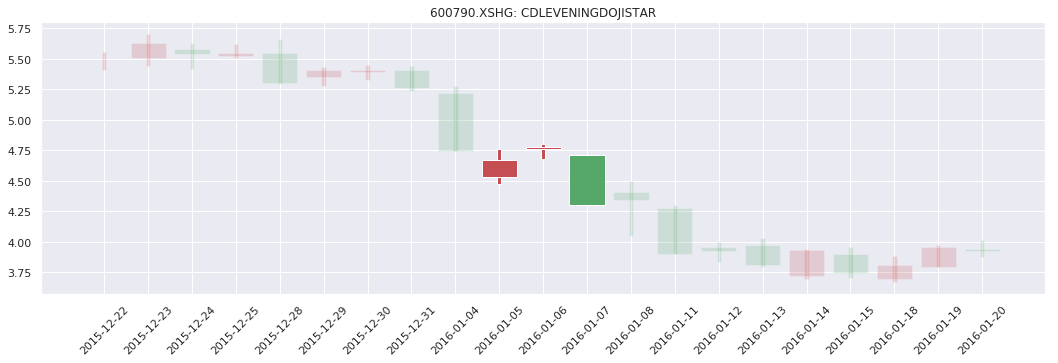

In [185]:
check_bar(tb.CDLEVENINGDOJISTAR, 3)

### CDLEVENINGSTAR - Evening Star
> 函数名：CDLEVENINGSTAR  
名称：Evening Star 暮星  
简介：三日K线模式，与晨星相反，上升趋势中,
第一日阳线，第二日价格振幅较小，第三日阴线，预示顶部反转。  

```python
integer = CDLEVENINGSTAR(open, high, low, close, penetration=0)
```

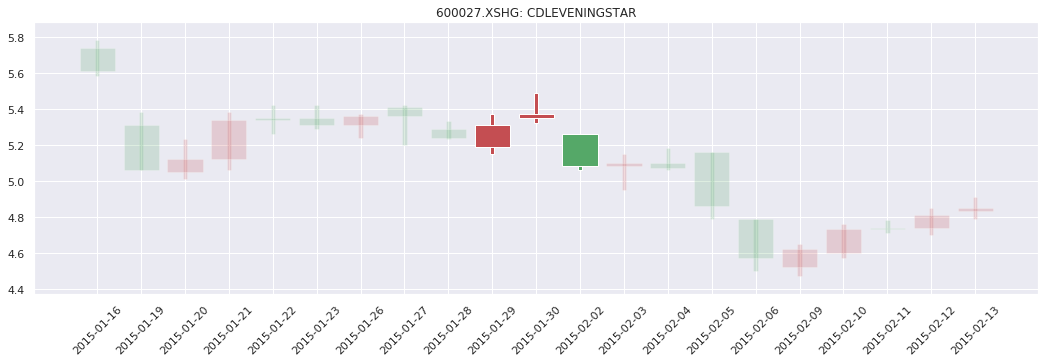

In [186]:
check_bar(tb.CDLEVENINGSTAR, 3)

### CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
>函数名：CDLGAPSIDESIDEWHITE  
名称：Up/Down-gap side-by-side white lines 向上/下跳空并列阳线  
简介：二日K线模式，上升趋势向上跳空，下跌趋势向下跳空,
第一日与第二日有相同开盘价，实体长度差不多，则趋势持续。  

```python
integer = CDLGAPSIDESIDEWHITE(open, high, low, close)
```

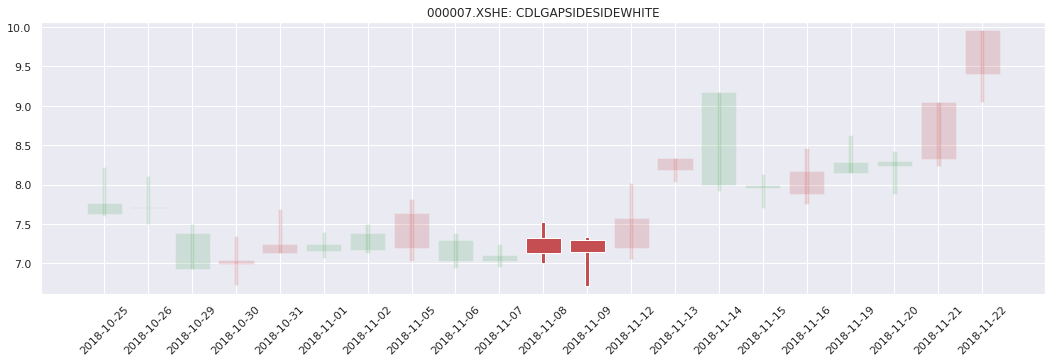

In [187]:
check_bar(tb.CDLGAPSIDESIDEWHITE, 2)

### CDLGRAVESTONEDOJI - Gravestone Doji
> 函数名：CDLGRAVESTONEDOJI  
名称：Gravestone Doji 墓碑十字/倒T十字  
简介：一日K线模式，开盘价与收盘价相同，上影线长，无下影线，预示底部反转。  

```python
integer = CDLGRAVESTONEDOJI(open, high, low, close)
```

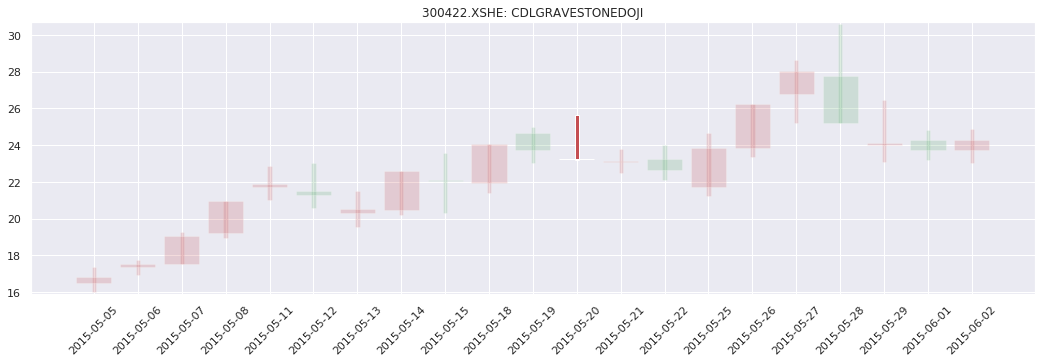

In [189]:
check_bar(tb.CDLGRAVESTONEDOJI, 1)

### CDLHAMMER - Hammer
> 函数名：CDLHAMMER  
名称：Hammer 锤头  
简介：一日K线模式，实体较短，无上影线，
下影线大于实体长度两倍，处于下跌趋势底部，预示反转。  

```python
integer = CDLHAMMER(open, high, low, close)
```

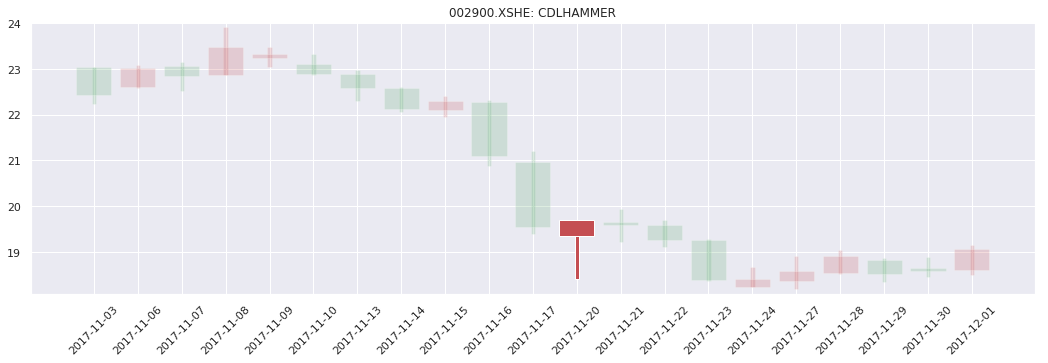

In [192]:
check_bar(tb.CDLHAMMER, 1)

### CDLHANGINGMAN - Hanging Man
> 函数名：CDLHANGINGMAN  
名称：Hanging Man 上吊线  
简介：一日K线模式，形状与锤子类似，处于上升趋势的顶部，预示着趋势反转。  

```python
integer = CDLHANGINGMAN(open, high, low, close)
```

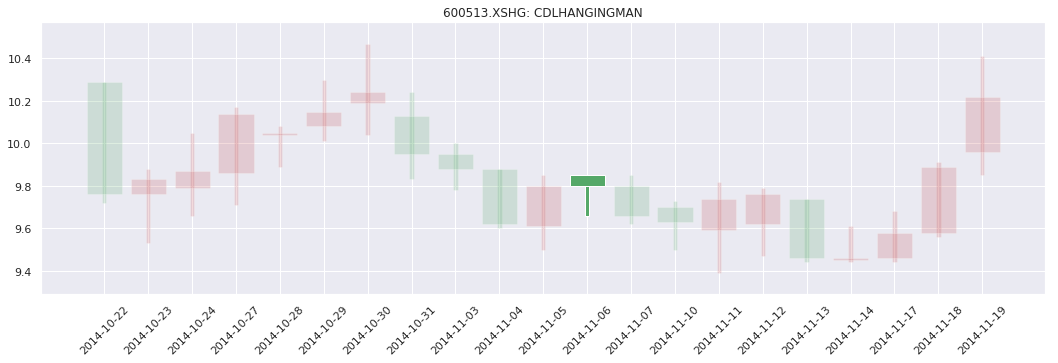

In [195]:
check_bar(tb.CDLHANGINGMAN, 1)

### CDLHARAMI - Harami Pattern
> 函数名：CDLHARAMI  
名称：Harami Pattern 母子线  
简介：二日K线模式，分多头母子与空头母子，两者相反，以多头母子为例，在下跌趋势中，第一日K线长阴，
第二日开盘价收盘价在第一日价格振幅之内，为阳线，预示趋势反转，股价上升。  

```python
integer = CDLHARAMI(open, high, low, close)
```

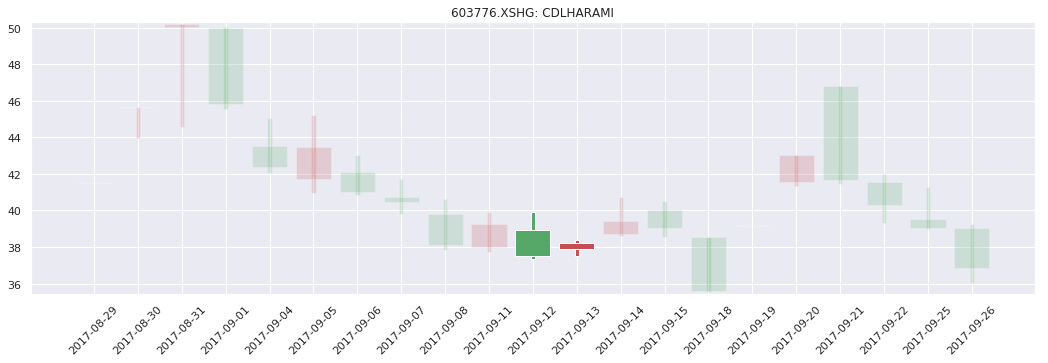

In [196]:
check_bar(tb.CDLHARAMI, 2)

### CDLHARAMICROSS - Harami Cross Pattern
> 函数名：CDLHARAMICROSS  
名称：Harami Cross Pattern 十字孕线  
简介：二日K线模式，与母子县类似，若第二日K线是十字线，
便称为十字孕线，预示着趋势反转。  

```python
integer = CDLHARAMICROSS(open, high, low, close)
```

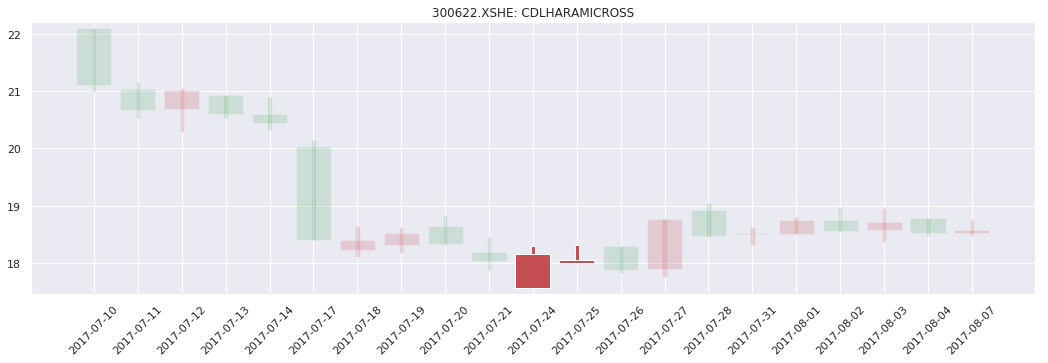

In [197]:
check_bar(tb.CDLHARAMICROSS, 2)

### CDLHIGHWAVE - High-Wave Candle
> 函数名：CDLHIGHWAVE  
名称：High-Wave Candle 风高浪大线  
简介：三日K线模式，具有极长的上/下影线与短的实体，预示着趋势反转。  

```python
integer = CDLHIGHWAVE(open, high, low, close)
```

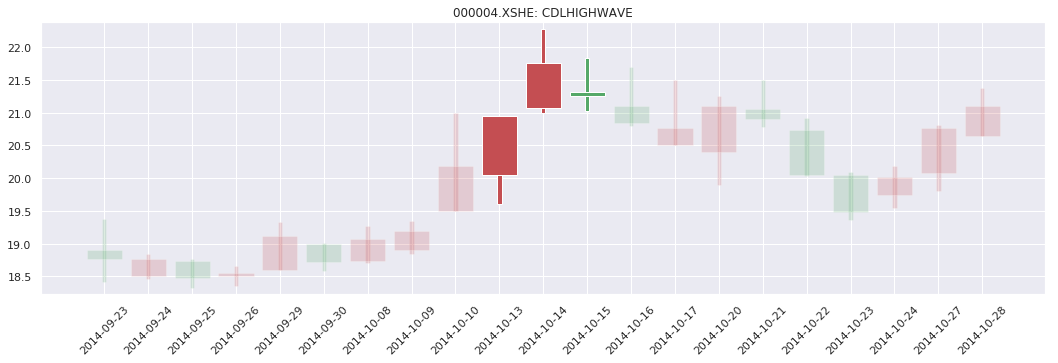

In [198]:
check_bar(tb.CDLHIGHWAVE, 3)

### CDLHIKKAKE - Hikkake Pattern
> 函数名：CDLHIKKAKE  
名称：Hikkake Pattern 陷阱  
简介：三日K线模式，与母子类似，第二日价格在前一日实体范围内,
第三日收盘价高于前两日，反转失败，趋势继续。  
```python
integer = CDLHIKKAKE(open, high, low, close)
```

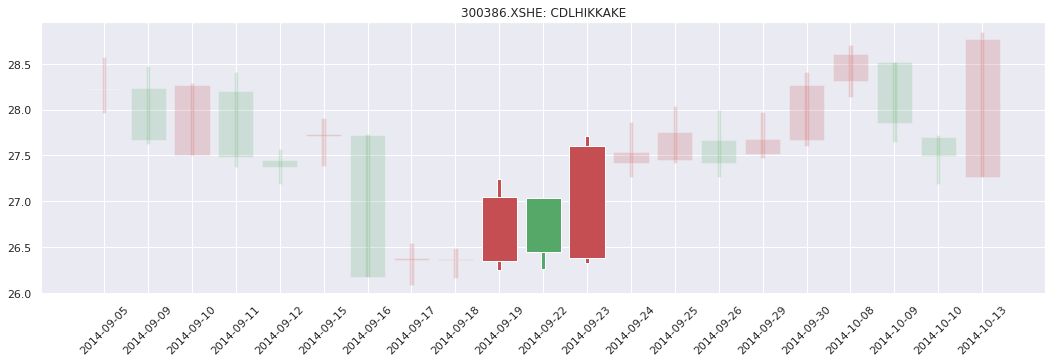

In [200]:
check_bar(tb.CDLHIKKAKE, 3)

### CDLHIKKAKEMOD - Modified Hikkake Pattern
> 函数名：CDLHIKKAKEMOD  
名称：Modified Hikkake Pattern 修正陷阱  
简介：三日K线模式，与陷阱类似，上升趋势中，第三日跳空高开；
下跌趋势中，第三日跳空低开，反转失败，趋势继续。
```python
integer = CDLHIKKAKEMOD(open, high, low, close)
```

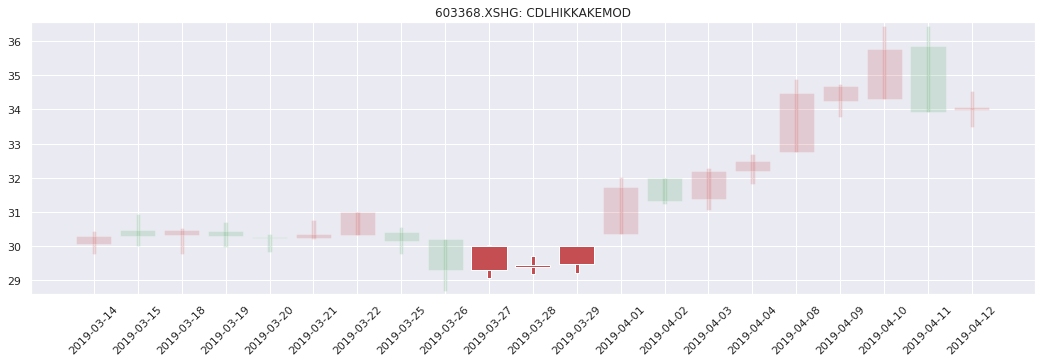

In [201]:
check_bar(tb.CDLHIKKAKEMOD, 3)

### CDLHOMINGPIGEON - Homing Pigeon
> 函数名：CDLHOMINGPIGEON  
名称：Homing Pigeon 家鸽  
简介：二日K线模式，与母子线类似，不同的的是二日K线颜色相同，
第二日最高价、最低价都在第一日实体之内，预示着趋势反转。  

```python
integer = CDLHOMINGPIGEON(open, high, low, close)
```

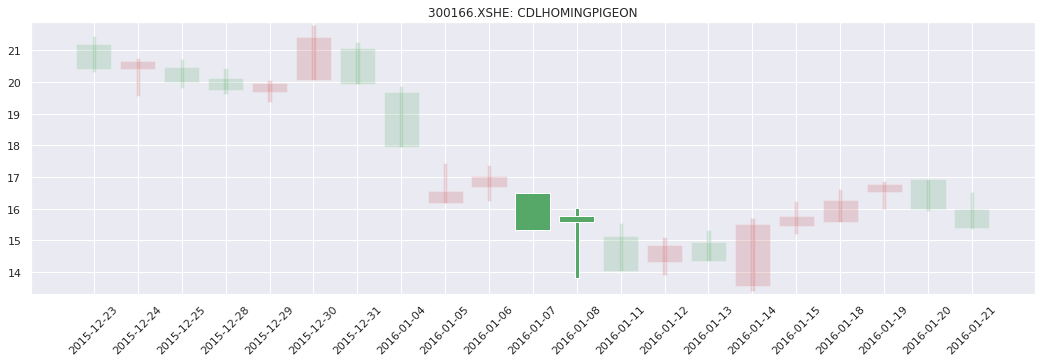

In [203]:
check_bar(tb.CDLHOMINGPIGEON, 2)

### CDLIDENTICAL3CROWS - Identical Three Crows
> 函数名：CDLIDENTICAL3CROWS  
名称：Identical Three Crows 三胞胎乌鸦  
简介：三日K线模式，上涨趋势中，三日都为阴线，长度大致相等，
每日开盘价等于前一日收盘价，收盘价接近当日最低价，预示价格下跌。  

```python
integer = CDLIDENTICAL3CROWS(open, high, low, close)
```

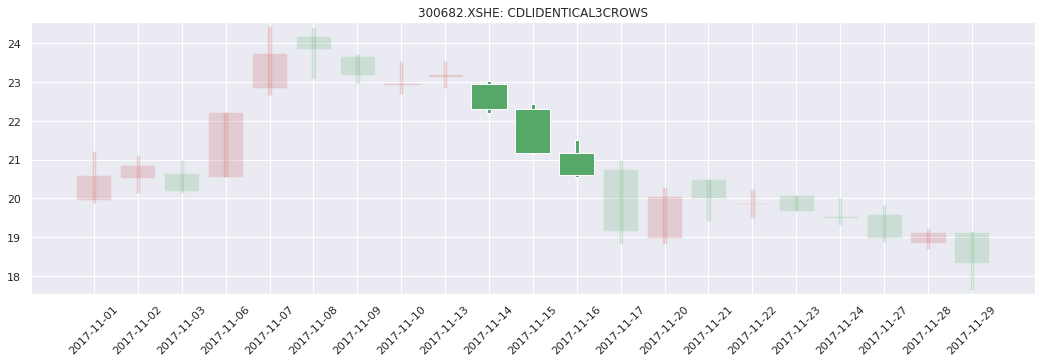

In [204]:
check_bar(tb.CDLIDENTICAL3CROWS, 3)

### CDLINNECK - In-Neck Pattern
>函数名：CDLINNECK  
名称：In-Neck Pattern 颈内线  
简介：二日K线模式，下跌趋势中，第一日长阴线，
第二日开盘价较低，收盘价略高于第一日收盘价，阳线，实体较短，预示着下跌继续。  

```python
integer = CDLINNECK(open, high, low, close)
```

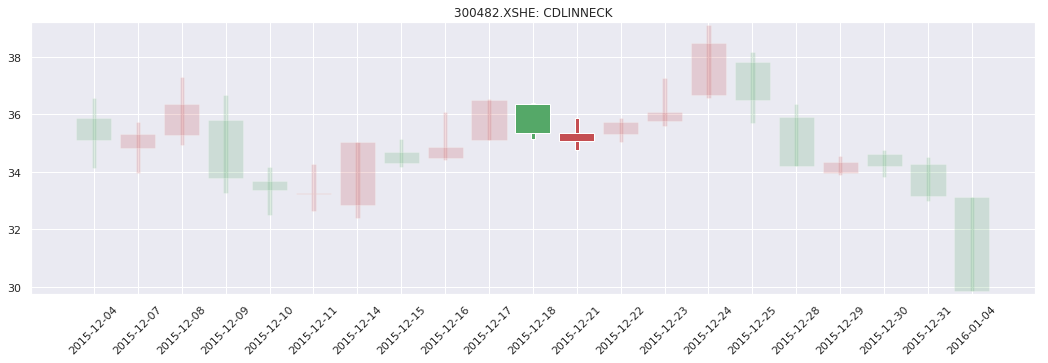

In [205]:
check_bar(tb.CDLINNECK, 2)

### CDLINVERTEDHAMMER - Inverted Hammer
> 函数名：CDLINVERTEDHAMMER  
名称：Inverted Hammer 倒锤头  
简介：一日K线模式，上影线较长，长度为实体2倍以上，
无下影线，在下跌趋势底部，预示着趋势反转。  

```python
integer = CDLINVERTEDHAMMER(open, high, low, close)
```

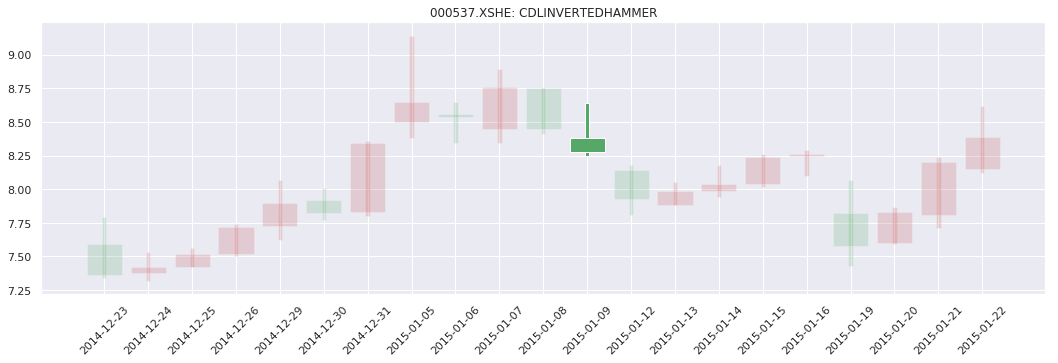

In [206]:
check_bar(tb.CDLINVERTEDHAMMER, 1)

### CDLKICKING - Kicking
> 函数名：CDLKICKING  
名称：Kicking 反冲形态  
简介：二日K线模式，与分离线类似，两日K线为秃线，颜色相反，存在跳空缺口。  

```python
integer = CDLKICKING(open, high, low, close)
```

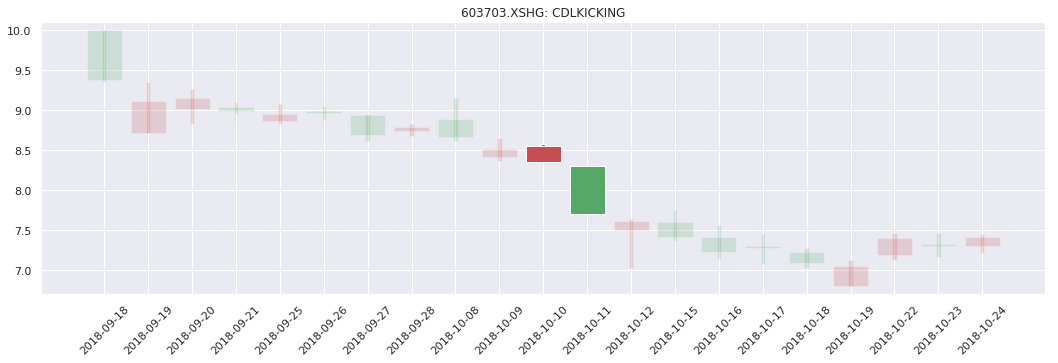

In [207]:
check_bar(tb.CDLKICKING, 2)

### CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
> 函数名：CDLKICKINGBYLENGTH  
名称：Kicking - bull/bear determined by the longer marubozu 由较长缺影线决定的反冲形态  
简介：二日K线模式，与反冲形态类似，较长缺影线决定价格的涨跌。  

```python
integer = CDLKICKINGBYLENGTH(open, high, low, close)
```

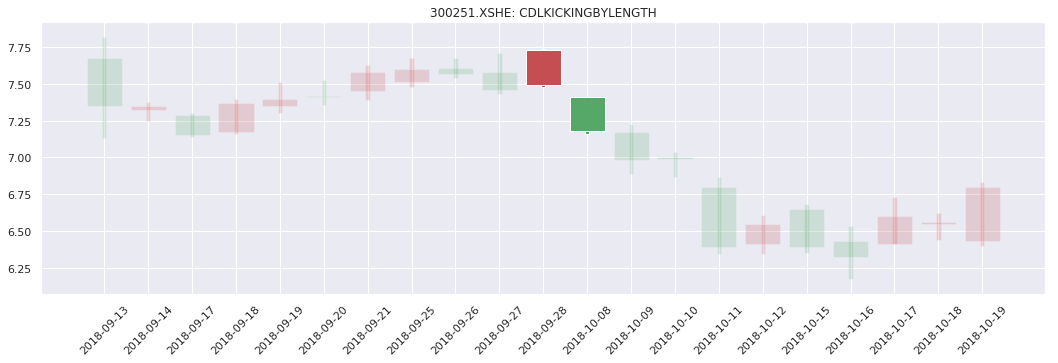

In [208]:
check_bar(tb.CDLKICKINGBYLENGTH, 2)

### CDLLADDERBOTTOM - Ladder Bottom 
> 函数名：CDLLADDERBOTTOM  
名称：Ladder Bottom 梯底  
简介：五日K线模式，下跌趋势中，前三日阴线，
开盘价与收盘价皆低于前一日开盘、收盘价，第四日倒锤头，第五日开盘价高于前一日开盘价，
阳线，收盘价高于前几日价格振幅，预示着底部反转。  

```python
integer = CDLLADDERBOTTOM(open, high, low, close)
```

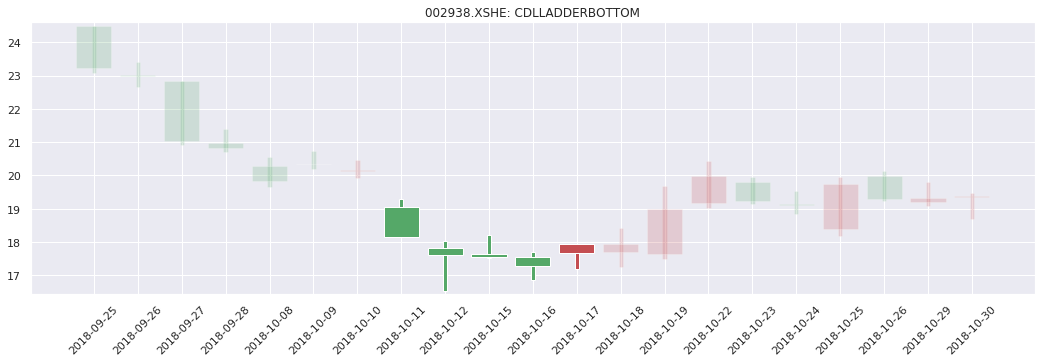

In [209]:
check_bar(tb.CDLLADDERBOTTOM, 5)

### CDLLONGLEGGEDDOJI - Long Legged Doji

> 函数名：CDLLONGLEGGEDDOJI  
名称：Long Legged Doji 长脚十字  
简介：一日K线模式，开盘价与收盘价相同居当日价格中部，上下影线长，
表达市场不确定性。  

```python
integer = CDLLONGLEGGEDDOJI(open, high, low, close)
```

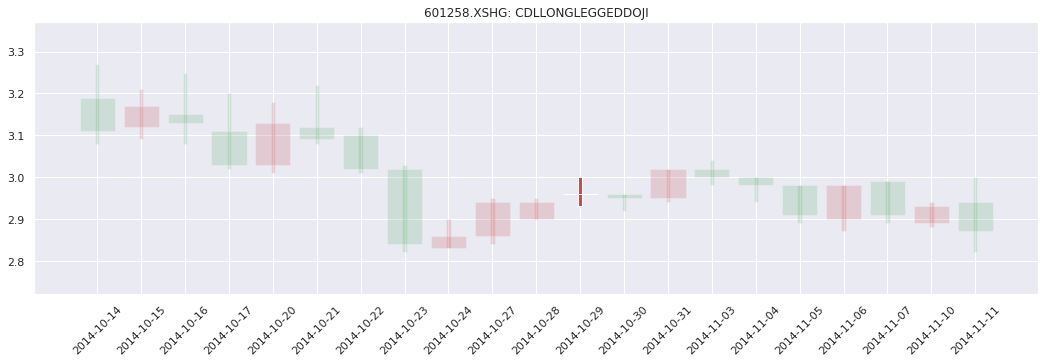

In [210]:
check_bar(tb.CDLLONGLEGGEDDOJI, 1)

### CDLLONGLINE - Long Line Candle
> 函数名：CDLLONGLINE  
名称：Long Line Candle 长蜡烛  
简介：一日K线模式，K线实体长，无上下影线。  

```python
integer = CDLLONGLINE(open, high, low, close)
```

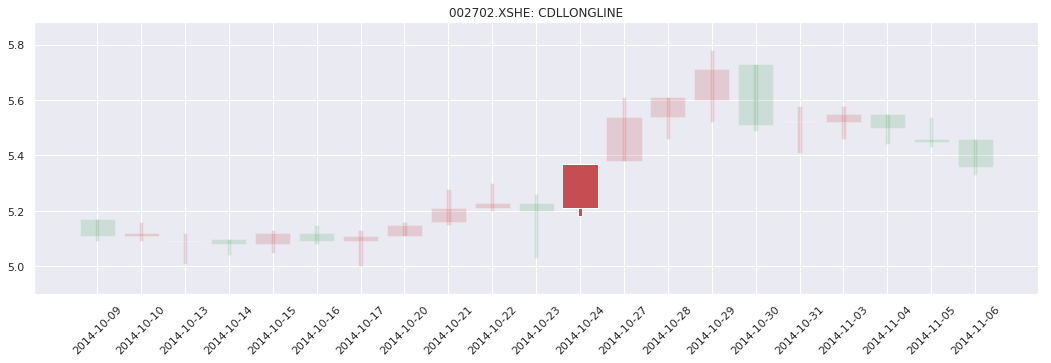

In [211]:
check_bar(tb.CDLLONGLINE, 1)

### CDLMARUBOZU - Marubozu
> 函数名：CDLMARUBOZU   
名称：Marubozu 光头光脚/缺影线  
简介：一日K线模式，上下两头都没有影线的实体，
阴线预示着熊市持续或者牛市反转，阳线相反。  

```python
integer = CDLMARUBOZU(open, high, low, close)
```

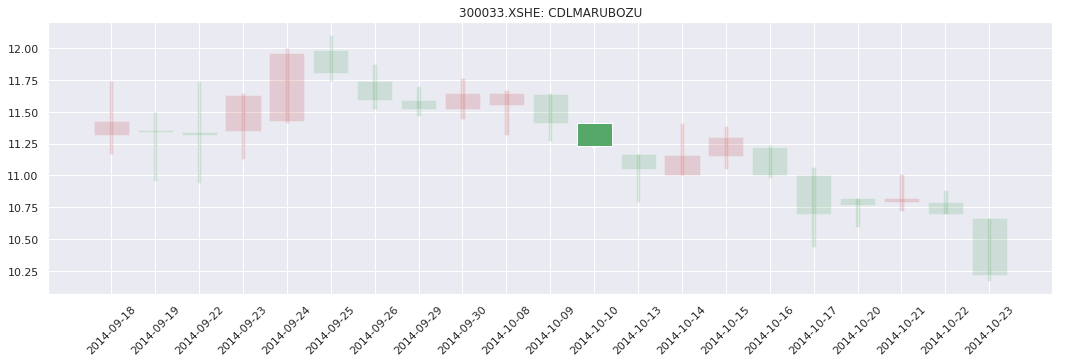

In [212]:
check_bar(tb.CDLMARUBOZU, 1)

### CDLMATCHINGLOW - Matching Low
> 函数名：CDLMATCHINGLOW  
名称：Matching Low 相同低价  
简介：二日K线模式，下跌趋势中，第一日长阴线，
第二日阴线，收盘价与前一日相同，预示底部确认，该价格为支撑位。  

```python
integer = CDLMATCHINGLOW(open, high, low, close)
```

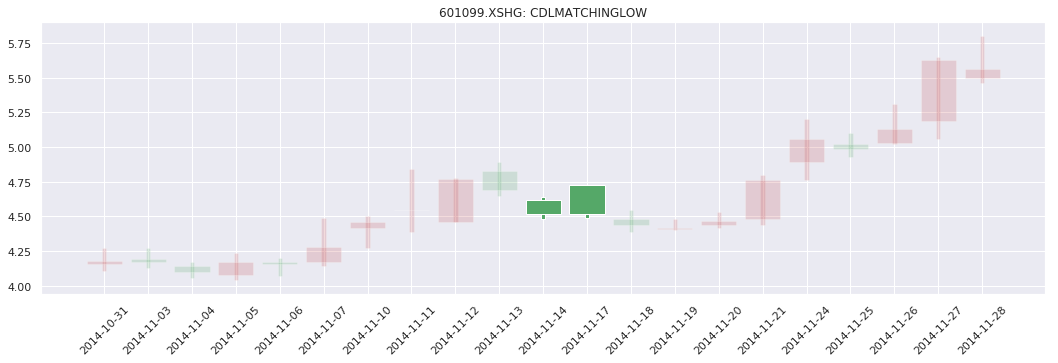

In [213]:
check_bar(tb.CDLMATCHINGLOW, 2)

### CDLMATHOLD - Mat Hold
> 函数名：CDLMATHOLD  
名称：Mat Hold 铺垫  
简介：五日K线模式，上涨趋势中，第一日阳线，第二日跳空高开影线，
第三、四日短实体影线，第五日阳线，收盘价高于前四日，预示趋势持续。  

```python
integer = CDLMATHOLD(open, high, low, close, penetration=0)
```

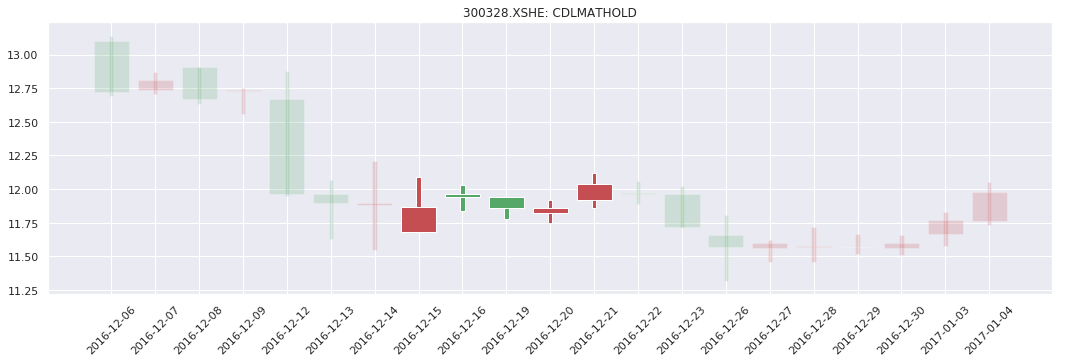

In [214]:
check_bar(tb.CDLMATHOLD, 5)

### CDLMORNINGDOJISTAR - Morning Doji Star
>函数名：CDLMORNINGDOJISTAR  
名称：Morning Doji Star 十字晨星  
简介：三日K线模式，
基本模式为晨星，第二日K线为十字星，预示底部反转。  


```python
integer = CDLMORNINGDOJISTAR(open, high, low, close, penetration=0)
```

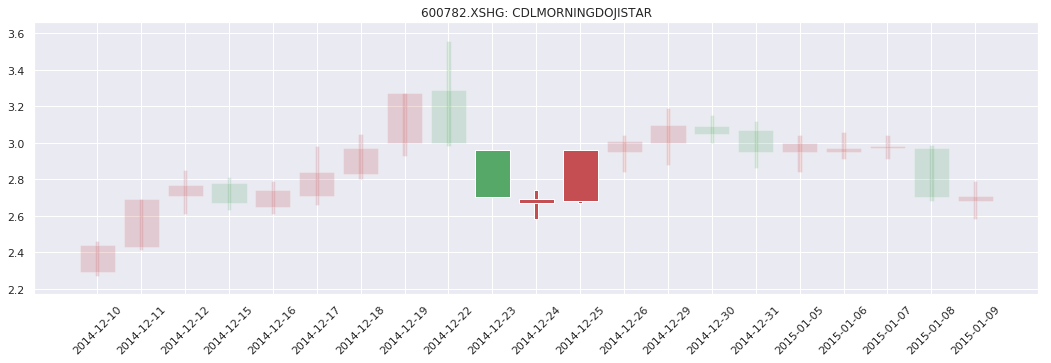

In [215]:
check_bar(tb.CDLMORNINGDOJISTAR, 3)

### CDLMORNINGSTAR - Morning Star
> 函数名：CDLMORNINGSTAR  
名称：Morning Star 晨星  
简介：三日K线模式，下跌趋势，第一日阴线，
第二日价格振幅较小，第三天阳线，预示底部反转。  

```python
integer = CDLMORNINGSTAR(open, high, low, close, penetration=0)
```

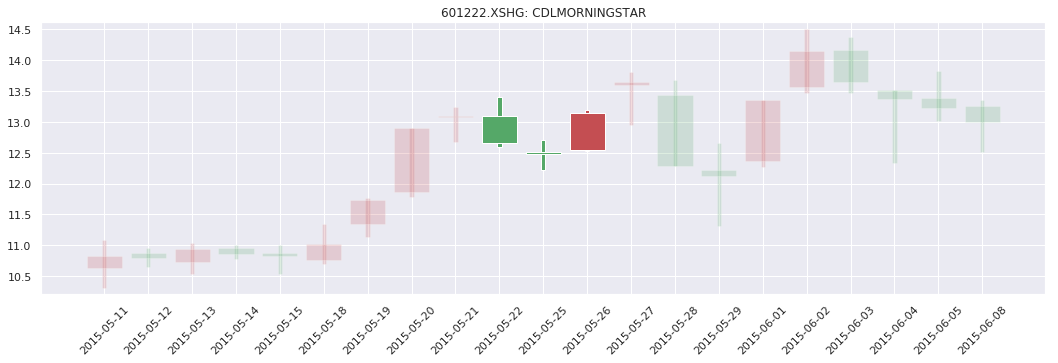

In [216]:
check_bar(tb.CDLMORNINGSTAR, 3)

### CDLONNECK - On-Neck Pattern
> 函数名：CDLONNECK  
名称：On-Neck Pattern 颈上线  
简介：二日K线模式，下跌趋势中，第一日长阴线，第二日开盘价较低，
收盘价与前一日最低价相同，阳线，实体较短，预示着延续下跌趋势。  

```python
integer = CDLONNECK(open, high, low, close)
```

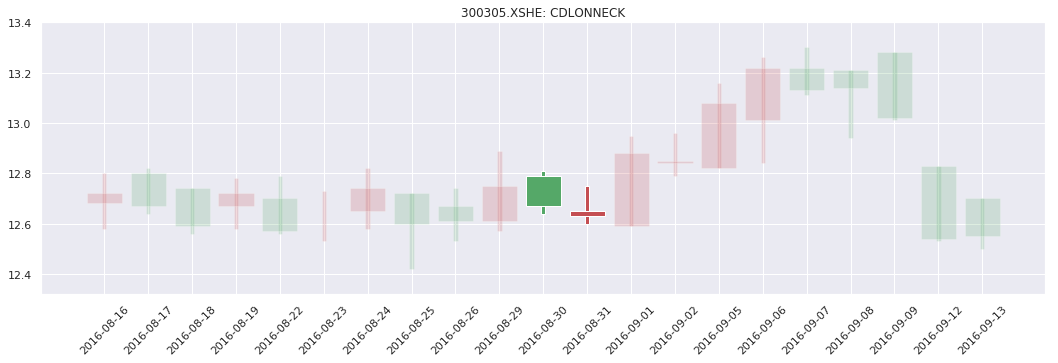

In [217]:
check_bar(tb.CDLONNECK, 2)

### CDLPIERCING - Piercing Pattern
> 函数名：CDLPIERCING  
名称：Piercing Pattern 刺透形态  
简介：两日K线模式，下跌趋势中，第一日阴线，第二日收盘价低于前一日最低价，
收盘价处在第一日实体上部，预示着底部反转。
```python
integer = CDLPIERCING(open, high, low, close)
```

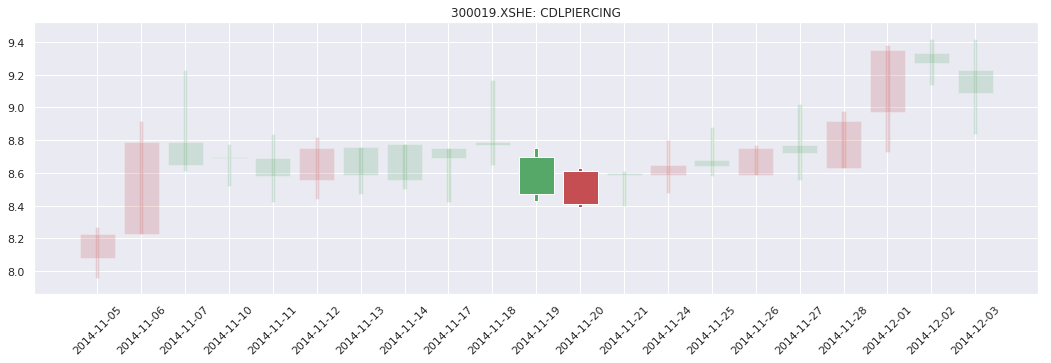

In [218]:
check_bar(tb.CDLPIERCING, 2)

### CDLRICKSHAWMAN - Rickshaw Man
> 函数名：CDLRICKSHAWMAN  
名称：Rickshaw Man 黄包车夫  
简介：一日K线模式，与长腿十字线类似，
若实体正好处于价格振幅中点，称为黄包车夫。  

```python
integer = CDLRICKSHAWMAN(open, high, low, close)
```

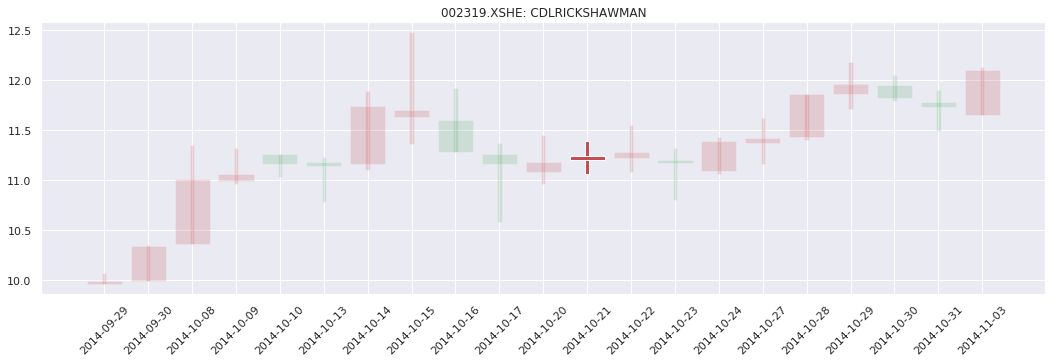

In [219]:
check_bar(tb.CDLRICKSHAWMAN, 1)

### CDLRISEFALL3METHODS - Rising/Falling Three Methods
> 函数名：CDLRISEFALL3METHODS
名称：Rising/Falling Three Methods 上升/下降三法  
简介： 五日K线模式，以上升三法为例，上涨趋势中，
第一日长阳线，中间三日价格在第一日范围内小幅震荡，
第五日长阳线，收盘价高于第一日收盘价，预示股价上升。  

```python
integer = CDLRISEFALL3METHODS(open, high, low, close)
```

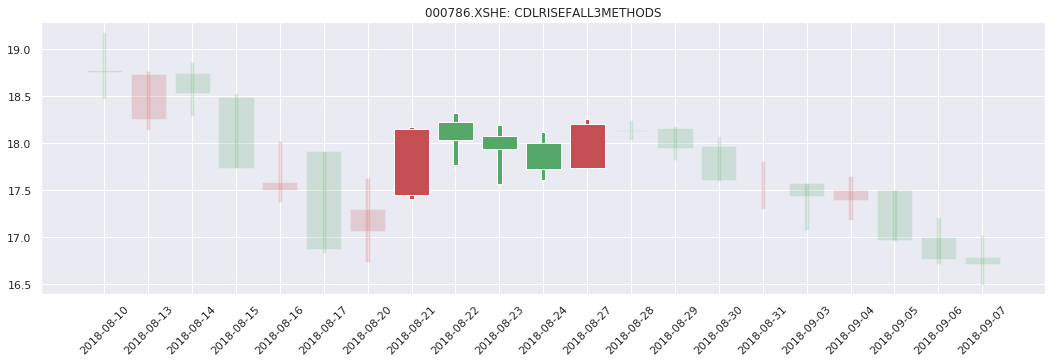

In [220]:
check_bar(tb.CDLRISEFALL3METHODS, 5)

### CDLSEPARATINGLINES - Separating Lines
> 函数名：CDLSEPARATINGLINES  
名称：Separating Lines 分离线  
简介：二日K线模式，上涨趋势中，第一日阴线，第二日阳线，
第二日开盘价与第一日相同且为最低价，预示着趋势继续。  

```python
integer = CDLSEPARATINGLINES(open, high, low, close)
```

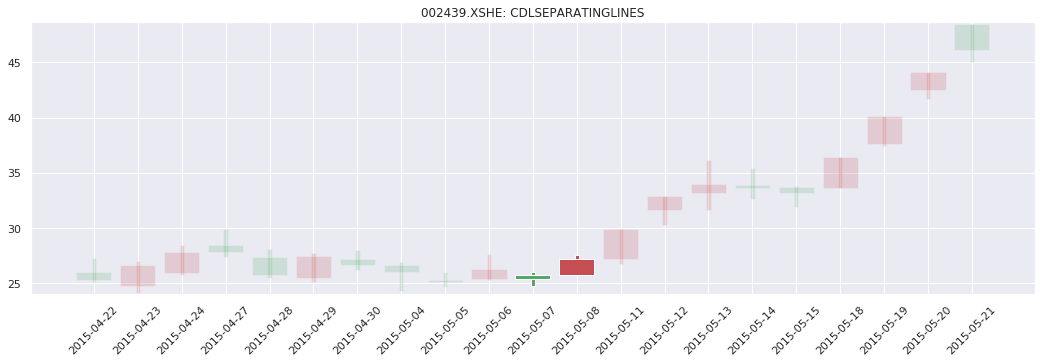

In [221]:
check_bar(tb.CDLSEPARATINGLINES, 2)

### CDLSHOOTINGSTAR - Shooting Star
> 函数名：CDLSHOOTINGSTAR  
名称：Shooting Star 射击之星  
简介：一日K线模式，上影线至少为实体长度两倍，
没有下影线，预示着股价下跌  
```python
integer = CDLSHOOTINGSTAR(open, high, low, close)
```

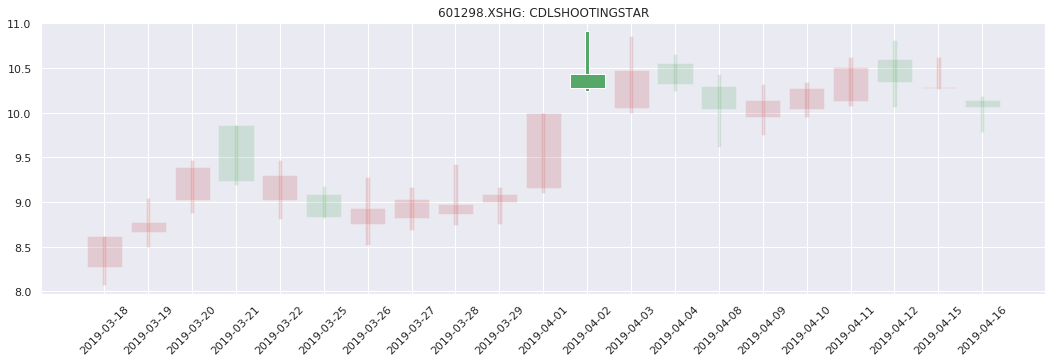

In [222]:
check_bar(tb.CDLSHOOTINGSTAR, 1)

### CDLSHORTLINE - Short Line Candle
> 函数名：CDLSHORTLINE  
名称：Short Line Candle 短蜡烛  
简介：一日K线模式，实体短，无上下影线  

```python
integer = CDLSHORTLINE(open, high, low, close)
```

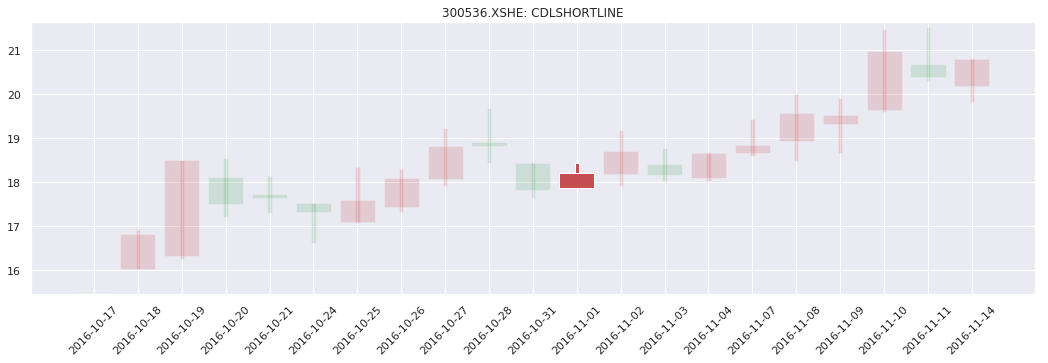

In [223]:
check_bar(tb.CDLSHORTLINE, 1)

### CDLSPINNINGTOP - Spinning Top
> 函数名：CDLSPINNINGTOP  
名称：Spinning Top 纺锤  
简介：一日K线，实体小。  

```python
integer = CDLSPINNINGTOP(open, high, low, close)
```

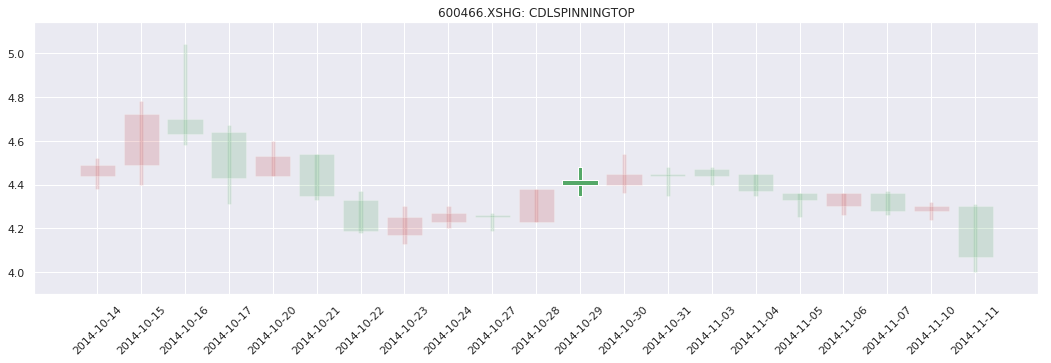

In [225]:
check_bar(tb.CDLSPINNINGTOP, 1)

### CDLSTALLEDPATTERN - Stalled Pattern
> 函数名：CDLSTALLEDPATTERN  
名称：Stalled Pattern 停顿形态  
简介：三日K线模式，上涨趋势中，第二日长阳线，
第三日开盘于前一日收盘价附近，短阳线，预示着上涨结束  

```python
integer = CDLSTALLEDPATTERN(open, high, low, close)
```

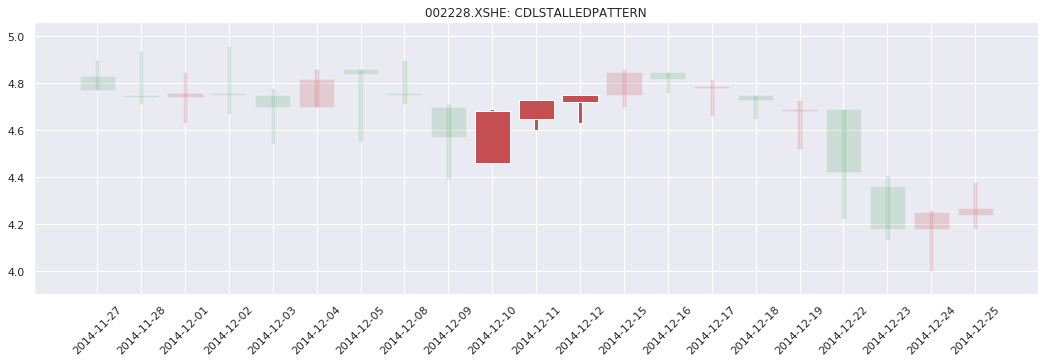

In [226]:
check_bar(tb.CDLSTALLEDPATTERN, 3)

### CDLSTICKSANDWICH - Stick Sandwich
> 函数名：CDLSTICKSANDWICH  
名称：Stick Sandwich 条形三明治  
简介：三日K线模式，第一日长阴线，第二日阳线，开盘价高于前一日收盘价，
第三日开盘价高于前两日最高价，收盘价于第一日收盘价相同。  

```python
integer = CDLSTICKSANDWICH(open, high, low, close)
```

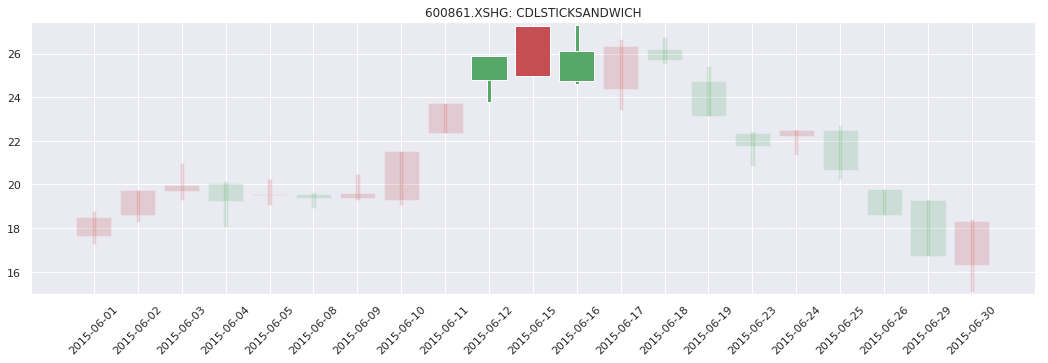

In [229]:
check_bar(tb.CDLSTICKSANDWICH, 3)

### CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
> 函数名：CDLTAKURI  
名称：Takuri (Dragonfly Doji with very long lower shadow) 
探水竿  
简介：一日K线模式，大致与蜻蜓十字相同，下影线长度长。  

```python
integer = CDLTAKURI(open, high, low, close)
```

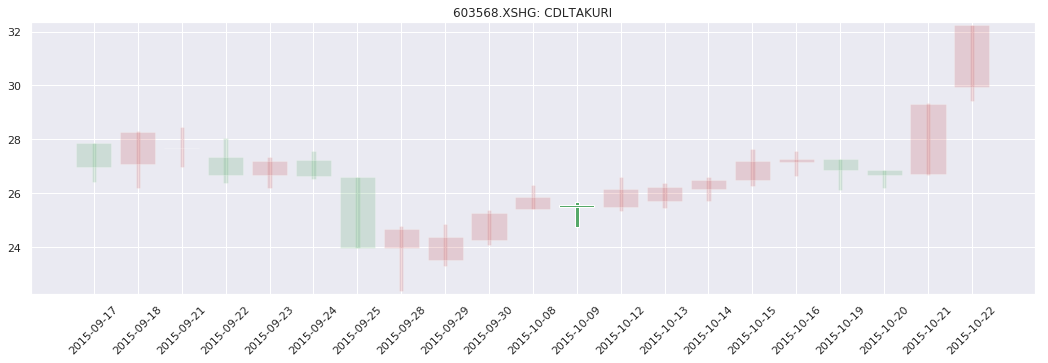

In [234]:
check_bar(tb.CDLTAKURI, 1)

### CDLTASUKIGAP - Tasuki Gap
> 函数名：CDLTASUKIGAP  
名称：Tasuki Gap 跳空并列阴阳线  
简介：三日K线模式，分上涨和下跌，以上升为例，
前两日阳线，第二日跳空，第三日阴线，收盘价于缺口中，上升趋势持续。  

```python
integer = CDLTASUKIGAP(open, high, low, close)
```

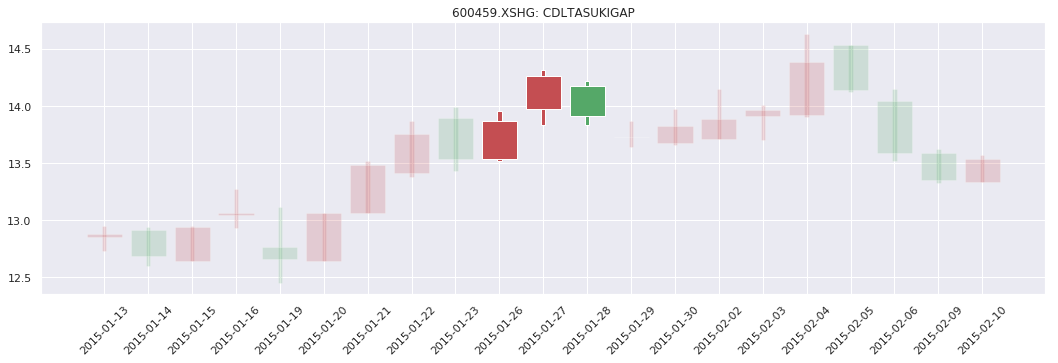

In [237]:
check_bar(tb.CDLTASUKIGAP, 3)

### CDLTHRUSTING - Thrusting Pattern
> 函数名：CDLTHRUSTING  
名称：Thrusting Pattern 插入  
简介：二日K线模式，与颈上线类似，下跌趋势中，第一日长阴线，第二日开盘价跳空，
收盘价略低于前一日实体中部，与颈上线相比实体较长，预示着趋势持续。  

```python
integer = CDLTHRUSTING(open, high, low, close)
```

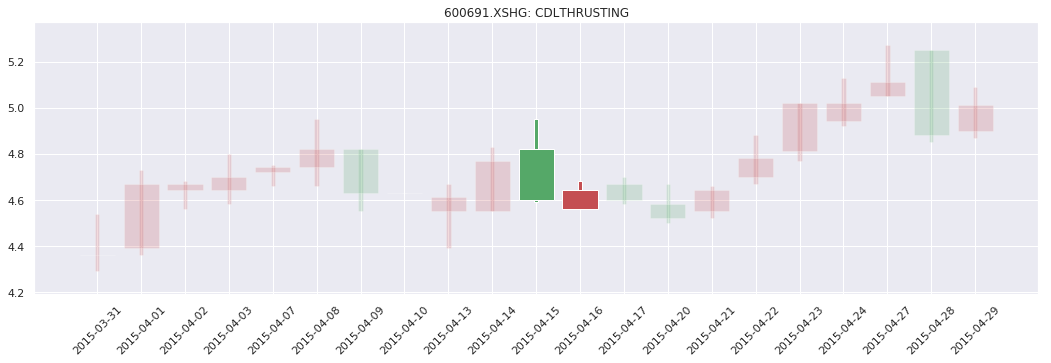

In [238]:
check_bar(tb.CDLTHRUSTING, 2)

### CDLTRISTAR - Tristar Pattern
> 函数名：CDLTRISTAR  
名称：Tristar Pattern 三星  
简介：三日K线模式，由三个十字组成，
第二日十字必须高于或者低于第一日和第三日，预示着反转。  

```python
integer = CDLTRISTAR(open, high, low, close)
```

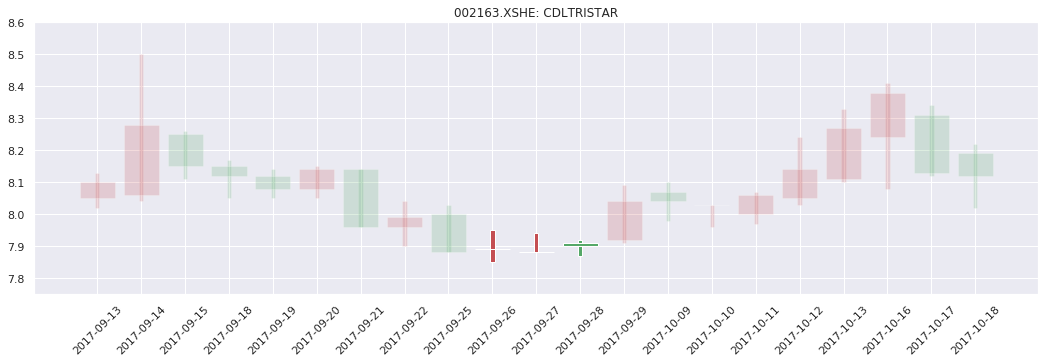

In [239]:
check_bar(tb.CDLTRISTAR, 3)

### CDLUNIQUE3RIVER - Unique 3 River
> 函数名：CDLUNIQUE3RIVER  
名称：Unique 3 River 奇特三河床  
简介：三日K线模式，下跌趋势中，第一日长阴线，第二日为锤头，最低价创新低，第三日开盘价低于第二日收盘价，收阳线，
收盘价不高于第二日收盘价，预示着反转，第二日下影线越长可能性越大。  

```python
integer = CDLUNIQUE3RIVER(open, high, low, close)
```

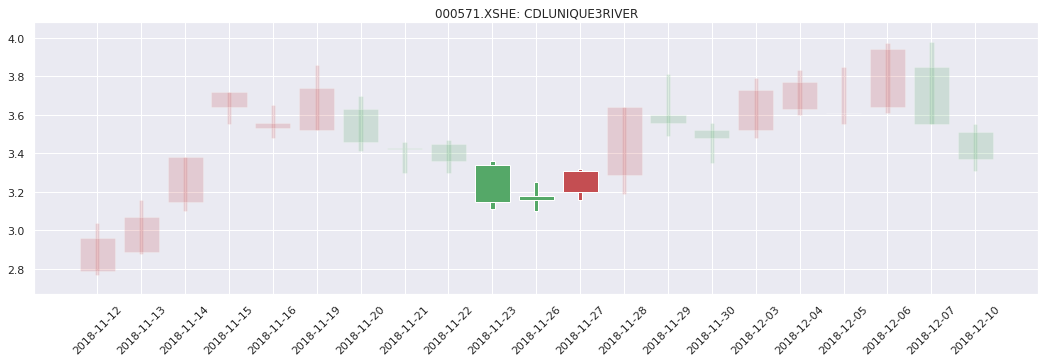

In [240]:
check_bar(tb.CDLUNIQUE3RIVER, 3)

### CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
> 函数名：CDLUPSIDEGAP2CROWS  
名称：Upside Gap Two Crows 向上跳空的两只乌鸦  
简介：三日K线模式，第一日阳线，第二日跳空以高于第一日最高价开盘，
收阴线，第三日开盘价高于第二日，收阴线，与第一日比仍有缺口。  

```python
integer = CDLUPSIDEGAP2CROWS(open, high, low, close)
```

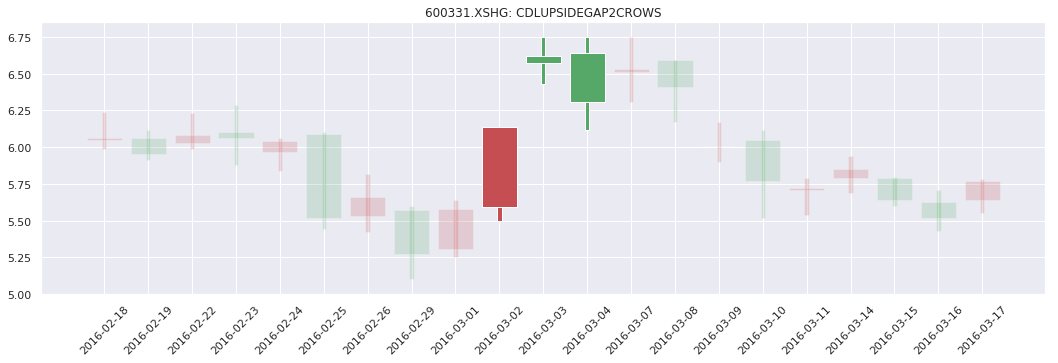

In [241]:
check_bar(tb.CDLUPSIDEGAP2CROWS, 3)

### CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
> 函数名：CDLXSIDEGAP3METHODS  
名称：Upside/Downside Gap Three Methods 上升/下降跳空三法  
简介：五日K线模式，以上升跳空三法为例，上涨趋势中，第一日长阳线，第二日短阳线，第三日跳空阳线，第四日阴线，开盘价与收盘价于前两日实体内，
第五日长阳线，收盘价高于第一日收盘价，预示股价上升。  

```python
integer = CDLXSIDEGAP3METHODS(open, high, low, close)
```

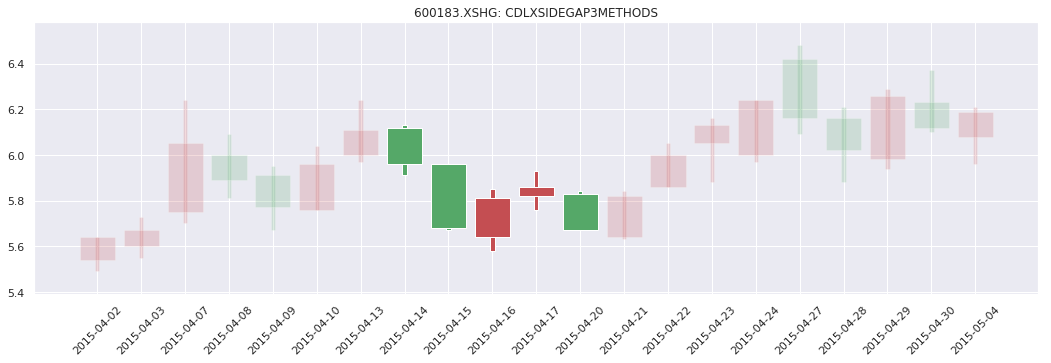

In [242]:
check_bar(tb.CDLXSIDEGAP3METHODS, 5)

## 使用案例

下面写一个 demo，追踪标的在指定日期形成的K线模式。

In [4]:
# 检查某标的在某日形成的形态，返回形态描述
def discern_pattern(security, date):
    from talib import abstract
    pattern_function = tb.get_function_groups()['Pattern Recognition']
    for name in pattern_function:
        func = abstract.Function(name)
        price = get_price(security, end_date=date, count=100, 
                          skip_paused=True)[['open', 'high', 'low', 'close']]
        signal_series = func(price)
        if signal_series[-1] != 0:
            yield func.info['display_name']

In [5]:
# 测试
security_list = get_all_securities(date='2014-08-11').index.tolist()
np.random.shuffle(security_list)
for security in security_list[0: 10]:
    result = discern_pattern(security, '2014-08-11')
    print(security, list(result))

603111.XSHG []
600428.XSHG []
300096.XSHE ['Hikkake Pattern']
002392.XSHE ['Belt-hold', 'Closing Marubozu', 'Long Line Candle', 'Marubozu']
601880.XSHG []
002292.XSHE ['Three Outside Up/Down', 'Belt-hold']
600360.XSHG ['Belt-hold', 'Engulfing Pattern', 'Long Line Candle']
001696.XSHE ['Closing Marubozu', 'Hikkake Pattern']
002584.XSHE []
600276.XSHG ['Three Inside Up/Down', 'Belt-hold', 'Closing Marubozu', 'Hikkake Pattern', 'Long Line Candle', 'Marubozu']
